# CNN Language Model

In [50]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, re, json, time, shutil
import itertools, collections
from IPython.display import display, HTML
from collections import Counter

# NLTK for NLP utils and corpora
import nltk
from sklearn.metrics import classification_report, accuracy_score

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1.1"))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz

# Import model
#import cnnlm
reload(utils)

<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

Define environment variables

In [51]:
DATA_DIR = 'Data_Set/'
PROJECT_PATH = os.getcwd()
PROJECT_DATA = os.path.join(PROJECT_PATH, DATA_DIR)

## Process 20 newsgroup data as input to CNN

### 1. Load 20 newsgroup data

In [52]:
# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# Get newsgroup data
newsgroup_data_all = fetch_20newsgroups(subset = 'all', remove=('headers', 'footers', 'quotes'))
all_data, all_labels = newsgroup_data_all.data, newsgroup_data_all.target

# List of all the class labels
label_list = list(newsgroup_data_all.target_names)

# Print the class labels
i = 0
for label in label_list:
    print "class: %i\t = %s" %(i, label)
    i += 1

class: 0	 = alt.atheism
class: 1	 = comp.graphics
class: 2	 = comp.os.ms-windows.misc
class: 3	 = comp.sys.ibm.pc.hardware
class: 4	 = comp.sys.mac.hardware
class: 5	 = comp.windows.x
class: 6	 = misc.forsale
class: 7	 = rec.autos
class: 8	 = rec.motorcycles
class: 9	 = rec.sport.baseball
class: 10	 = rec.sport.hockey
class: 11	 = sci.crypt
class: 12	 = sci.electronics
class: 13	 = sci.med
class: 14	 = sci.space
class: 15	 = soc.religion.christian
class: 16	 = talk.politics.guns
class: 17	 = talk.politics.mideast
class: 18	 = talk.politics.misc
class: 19	 = talk.religion.misc


### 2. Determine the length of document to use

* From the distribution, must of the document is quite short. The original paper use **2000** word length which we can use this length or try other length if needed. 

* If a document is longer than the defined doc length, it will be cut, if it is shorter, it will be padded.

* < PAD > tag is used for padding

#### Document length distribution of 20 newsgroup data

* Does using 2000 document length makes sense?

Number of Samples: 4536, Max Length: 158791, Min Length: 0, Avg Length: 1255.431


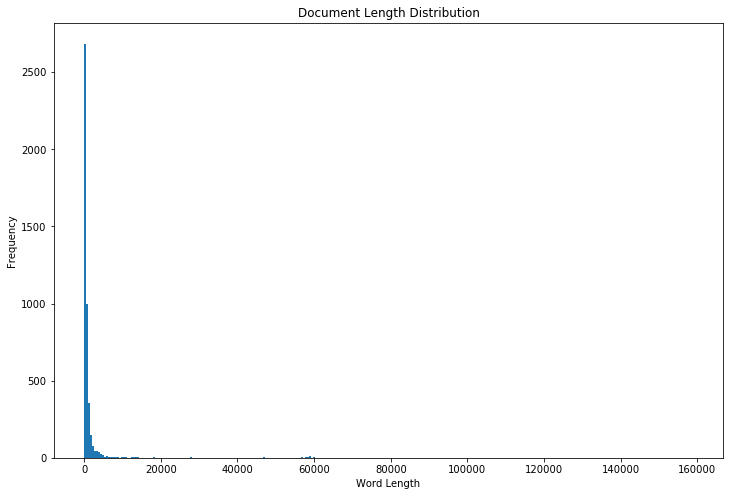

In [74]:
doc_len =[]
for doc in all_data:
    doc_len.append(len(doc))

# Document length statistics
print "Number of Samples: %i, Max Length: %i, Min Length: %i, Avg Length: %.3f" \
    %(len(doc_len), max(doc_len), min(doc_len), np.mean(doc_len))

plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(doc_len, 300)
plt.title("Document Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

### 3. Build Vocabulary using 20 newsgroup data set

* Load all data from library => remove header/footer/quotes => clean string => create corpus => build vocabulary

* To build corpus, we write to raw txt, then use NLTK to process the raw text to a corpus

In [54]:
from nltk.corpus import PlaintextCorpusReader

f = open('./Data_Set/newsgroup_prep/newsgroup_all.txt', 'w') 
for doc in all_data:
    # Clean up str
    doc = utils.clean_str((doc).encode('utf-8'))
    # remove stop words and do stemming optionaly
    doc = utils.preprocess_stop_stem(doc, stop=True, sent=True, stem=False)
    f.write("%s\n" %(doc))
f.close()

# RegEx or list of file names
data_20newsgroup = os.path.join(PROJECT_DATA, 'newsgroup_prep/')

corpus = PlaintextCorpusReader(data_20newsgroup, 'newsgroup_all.txt')

for infile in sorted(corpus.fileids()):
    print infile # The fileids of each file.

newsgroup_all.txt


In [55]:
V = 20000
vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) 
                               for w in utils.flatten(corpus.sents())),
                               size = V)
print "Vocabulary: %d words" % vocab.size

Vocabulary: 20000 words


### 4. Prepare Data for the CNN

### Option 1. Train word Embedding with CNN. 

#### Tokenize document and build input data for word2vec

* Load data => remove header/footer/quotes => cleaned string => cut and pad => use vocabulary to tokenize

* Need to enable randomly select a number of classes for training and test data

* Instead of using Sk-learn's building selection of train or test data. Build our own train/test data based on %split

In [56]:
# Select training and test data based on the number of classes
# Including randomization option
import random
from random import randint
random.seed(8)

num_class = 5
randomize = True

if randomize == True:
    label_idxs = []
    for x in range(num_class):
        label_idxs.append(randint(0, 19))
else:
    label_idxs = range(num_class)

select_classes = [label_list[i] for i in label_idxs]
print "Randomly Select Classes: ", select_classes

newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                                    categories=select_classes)

all_data, all_labels = newsgroups_all.data, newsgroups_all.target

Randomly Select Classes:  ['comp.sys.mac.hardware', 'talk.religion.misc', 'comp.os.ms-windows.misc', 'sci.space', 'comp.graphics']


In [57]:
doc_length = 200

# Preprocess data
# Cleaning special characters
# Cut or pad based on document length
all_docs = utils.preprocess_doc(all_data, length = doc_length)

train_docs, train_labels, test_docs, test_labels = utils.get_train_test_docs(all_docs, 
                                                                             all_labels, 
                                                                             split = 0.8, 
                                                                             shuffle = True)

Loaded 4536 docs (5.60058e+06 tokens)
Training set: 3628 docs (4477827 tokens)
Test set: 908 docs (1122749 tokens)


In [58]:
# Tokenize documents and conver to ID
# We tokenize each docs in the dataset and convert to vocab ID
# matrix of batch_size x doc_length
train_docs_ids = utils.docs_to_ids(train_docs, vocab)
test_docs_ids = utils.docs_to_ids(test_docs, vocab)

# Convert label to one-hot-code
train_labels_oh = np.eye(num_class)[train_labels]
test_labels_oh = np.eye(num_class)[test_labels]

print "Input Training Docs shape:", train_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Training labels shape:", train_labels_oh.shape, "should equal to (batch_size, num_class)"
print "Input Testing Docs shape:", test_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Testing labels shape:", test_labels_oh.shape, "should equal to (batch_size, num_class)"

Input Training Docs shape: (3628, 200) should equal to (batch_size, doc_length)
Input Training labels shape: (3628, 5) should equal to (batch_size, num_class)
Input Testing Docs shape: (908, 200) should equal to (batch_size, doc_length)
Input Testing labels shape: (908, 5) should equal to (batch_size, num_class)


### Option 2 Load Google Pretrained Word2vec

In [59]:
def load_google_bin(fname, vocab):
    """
    Loads 300x1 word vecs from Google (Mikolov) word2vec
    """
    word_vecs = {}
    with open(fname, "rb") as f:
        header = f.readline()
        vocab_size, layer1_size = map(int, header.split())
        print "Google Word2vec Vocabulary Size:", vocab_size
        print "Vector size:", layer1_size
        binary_len = np.dtype('float32').itemsize * layer1_size
        print "Binary Length of word vector:", binary_len
        for line in xrange(vocab_size):
            word = []
            while True: # Read 1 char a time
                ch = f.read(1) 
                if ch == ' ': # If it is a space, a word is read, we join then to read its vector
                    word = ''.join(word)
                    break
                if ch != '\n': # If it is not \n, grouping character
                    word.append(ch) 
            if word in vocab.wordset: # If a word in the 20 newsgroup vocab, get its vector
                word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')  
            else:
                f.read(binary_len)
    f.close()
    return word_vecs

In [60]:
google_word2vec = load_google_bin('./google_word2vec/GoogleNews-vectors-negative300.bin', vocab)

Google Word2vec Vocabulary Size: 3000000
Vector size: 300
Binary Length of word vector: 1200


In [61]:
print "Total Number of vocabulary in 20newsgroup:", vocab.size
print "Total matched vocabulary from google word2vec:", len(google_word2vec.keys())
print "--- Print a sample of google_word2vec vocabulary ---"
i = 0
for k, v in google_word2vec.iteritems():
    if i <= 10:
        print "Word: %s \t\t Vector: %s ..." %(k, v[:3])
    i += 1

Total Number of vocabulary in 20newsgroup: 20000
Total matched vocabulary from google word2vec: 16555
--- Print a sample of google_word2vec vocabulary ---
Word: raining 		 Vector: [ 0.02331543  0.05004883 -0.00059891] ...
Word: writings 		 Vector: [ 0.18945312  0.2109375   0.20507812] ...
Word: divinely 		 Vector: [-0.02783203 -0.40820312 -0.01037598] ...
Word: foul 		 Vector: [ 0.18847656 -0.28710938  0.33007812] ...
Word: four 		 Vector: [ 0.0859375  -0.07275391  0.01672363] ...
Word: gag 		 Vector: [ 0.14648438 -0.08203125 -0.00897217] ...
Word: prefix 		 Vector: [ 0.34570312  0.1640625   0.11425781] ...
Word: woods 		 Vector: [ 0.11328125 -0.01165771 -0.20800781] ...
Word: verses 		 Vector: [ 0.28710938  0.15820312  0.23828125] ...
Word: hanging 		 Vector: [ 0.08984375  0.13769531 -0.14941406] ...
Word: woody 		 Vector: [ 0.08251953  0.44140625  0.07421875] ...


#### Cross check vocabulary in 20newsgroup

In [62]:
regex = r'\b([A-Za-z]+)\b'
count_w = []
count_s = []
for word in vocab.wordset:    
    if re.search(regex, str(word)):
        count_w.append(str(word))
    else:
        count_s.append(str(word))

In [63]:
print "Number of full letter words", len(count_w)
print "Number of mixed ascii words", len(count_s)

Number of full letter words 18724
Number of mixed ascii words 1276


In [64]:
count_s[:5]

['u3', '51s', '51t', '2z', '9k']

#### Take care of unknown words from 20newsgroup that does not exist in google word2vec

* 0.25 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones

In [65]:
def add_unknown_words(google_word2vec, vocab, k=300):
    for word in vocab.wordset:
        if word not in google_word2vec:
            google_word2vec[word] = np.random.uniform(-0.25,0.25,k)  

In [66]:
add_unknown_words(google_word2vec, vocab, k=300)

In [67]:
print "Total Number of vocabulary in 20newsgroup:", vocab.size
print "Total matched vocabulary from google word2vec:", len(google_word2vec.keys())
pt_word2vec = np.array(google_word2vec.values())
print "Pre-trained word2vec size", pt_word2vec.shape

Total Number of vocabulary in 20newsgroup: 20000
Total matched vocabulary from google word2vec: 20000
Pre-trained word2vec size (20000, 300)


### CNN Illustrated

<img src="cnn.png" width = "80%">

### DOC Paper Terminology and Notes:

* Embedding Layer:

    * batch_size: N
    * number of class: M
    * A document matrix has size of $s \times d$
        * word embedding dimension: d => 300
        * doc length: s => 2000
    
    
* CNN Layer

    * Region size: h => [3, 4, 5]
    * Width of the filter: d => 300
    * Number of filters per region: f => 150
    * CNN out o: k => f x h = 150 x 3
    

* Output Layer
    * W: $r \times k$
    * W': $M \times r$
    * y: $M$

Note: The DOC Paper used a 2 fully connected output layer before softmax which is different from common approach

$$out = W'(ReLU(Wo + b)) + b'$$
    

### Define CNN Parameters

In [82]:
# CNN Paramters
# doc_length = 100 => to be aligned with DOC paper?
# num_class = 3 => to be adjusted based on stratified CV strategy from the DOC paper
# vocab.size => If we don't use google word2vec, it will be vocab.size from newsgroup data alone
# embedding_size => to be aligned with DOC paper
# filter_size = [3, 4] => to be aligned with DOC paper
# num_filters = 100 => to be aligned w

doc_length = doc_length # s
num_classes = num_class # M
vocab_size = vocab.size
embedding_size = 300 # d
embedding_train = True # if True, we train word embedding, if not we use pretrained word2vec
filter_sizes = [3, 4, 5]
num_filters = 150 # f
l2_reg_lambda = 0.0
dropout_prob = 0.5
hidden = 250 # r

In [83]:
# Placeholders for input, output and dropout
# x_: Document, Size: (batch, document_length) word in indice
# y_: Classes, Size: (batch, num_of_classes)
# dropout_keep_prob: Dropout regularization parameter

x_ = tf.placeholder(tf.int32, [None, doc_length], name="x")
y_ = tf.placeholder(tf.float32, [None, num_classes], name="y")
dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

# Embedding layer (Train embedding layer)
# Need different implementation if use google pretrained word2vec
with tf.name_scope("Embedding_Layer"):
    # The vocab to vector table for lookup (to be trained or pre-trained)
    if embedding_train:
        C_ = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="C")
    else:
        C_ = tf.placeholder(tf.float32, [vocab_size, embedding_size], name="C")
    
    # Embedding output needs to be in size: (batch, doc_length, embedding_size, 1)
    # Lookup gives (batch, doc_length, embedding_size)
    # Therefore, we need to expand the dimension to 4D to work with conv2d
    embedded_out = tf.expand_dims(tf.nn.embedding_lookup(C_, x_), -1)

# Create a convolution + maxpool layer for each filter size
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):
        
        # Convolution Layer
        # input shape: (batch, height(doc length, width(embedding size), channels(1) )
        # filter shape: (filter_height, filter width(same as embedding size), in_channel, out_channels)
        # in_channel = 1 for our data
        # out_channel = num_filters
        filter_shape = [filter_size, embedding_size, 1, num_filters]
        
        # To experiment with normal distribution
        W_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
        b_ = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
        
        # "VALID" padding means no padding at edge
        # Return shape (batch, height(doc length, width(embedding size), 1)
        conv_ = tf.nn.conv2d(embedded_out, W_, strides=[1, 1, 1, 1], padding="VALID", name="conv")
        
        # Apply nonlinearity using Relu (train fasster than tanh)
        # Return shape (batch, height(doc length, 1, 1)
        h_ = tf.nn.relu(tf.nn.bias_add(conv_, b_), name="relu")
        
        # Maxpooling over the outputs
        # ksize is window for pooling, we took 1 value for width direction
        # For height, apply to each convolution steps to stripe the whole input matrix.
        # Return shape (1, doc_length-filter_size+1, 1, 1)
        pooled = tf.nn.max_pool(h_, 
                                ksize=[1, doc_length - filter_size + 1, 1, 1],
                                strides=[1, 1, 1, 1], 
                                padding='VALID', 
                                name="pool")
        pooled_outputs.append(pooled)

# Combine all the pooled features
# find the total number of filters = num_of_filters * num_of_region
# If we use [2, 3, 4] and 2 filter per region, we have 3 * 2 = 6 filters
num_filters_total = num_filters * len(filter_sizes)

# combine pooling output to feature vectors
# h_pool_flat in shape of (batch_size, ? , num_filters_total)
h_pool = tf.concat(pooled_outputs, 3)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])

# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

# Output Layer: Softmax
# Final (unnormalized) scores and predictions
# Do we need to normalize?
with tf.name_scope("Output_layer"):
    Z1_ = tf.Variable(tf.random_uniform([num_filters_total, hidden], -1.0, 1.0), name = "Z1")
    Z2_ = tf.Variable(tf.random_uniform([hidden, num_classes], -1.0, 1.0), name = "Z2")
    b1_ = tf.Variable(tf.constant(0.1, shape=[hidden]), name="b1")
    b2_ = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b2")
    hidden_out = tf.nn.relu(tf.matmul(h_drop, Z1_) + b1_)
    logits_ = tf.add(tf.matmul(hidden_out, Z2_), b2_, name="logits")
    
    # L2 loss
    l2_loss += tf.nn.l2_loss(Z1_)
    l2_loss += tf.nn.l2_loss(b1_)
    l2_loss += tf.nn.l2_loss(Z2_)
    l2_loss += tf.nn.l2_loss(b2_)
    
    #scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    predictions_ = tf.argmax(logits_, 1, name="predictions")

# Calculate mean cross-entropy loss
with tf.name_scope("cost_function"):
    per_example_losses_ = tf.nn.softmax_cross_entropy_with_logits(logits=logits_, 
                                                                 labels=y_,
                                                                 name="per_example_loss")
    loss_ = tf.reduce_mean(per_example_losses_) + l2_reg_lambda * l2_loss

# Accuracy
with tf.name_scope("accuracy"):
    correct_predictions_ = tf.equal(predictions_, tf.argmax(y_, 1))
    accuracy_ = tf.reduce_mean(tf.cast(correct_predictions_, "float"), name="accuracy")


### Training with CNN

** 1. Train Word Embedding along with CNN **

Display parameters

In [84]:
print "doc_length: {:<10d}".format(doc_length) # s
print "num_classes: {:<10d}".format(num_class) # M
print "vocabulary size: {:<10d}".format(vocab.size)
print "embedding size: {:<10d}".format(embedding_size) # d
print "Train embedding? ", embedding_train
print "filter size: {:<10s}".format(filter_sizes)
print "number of filters: {:<10d}".format(num_filters)
print "L2 Regularization: {:<10.2f}".format(l2_reg_lambda)
print "Drop out prob: {:<10.2f}".format(dropout_prob)
print "Hidden before output: {:<10d}".format(hidden)

doc_length: 200       
num_classes: 5         
vocabulary size: 20000     
embedding size: 300       
Train embedding?  True
filter size: [3, 4, 5] 
number of filters: 150       
L2 Regularization: 0.00      
Drop out prob: 0.50      
Hidden before output: 250       


In [85]:
# Helper functions for training
def train_batch(session, batch, alpha, train_embedding):
    # Feed last column as targets
    if train_embedding:
        feed_dict = {x_:train_docs_ids,
                     y_:train_labels_oh,
                     dropout_keep_prob:dropout_prob, # No dropout
                     alpha_:alpha}
    else:
        feed_dict = {x_:train_docs_ids,
                     y_:train_labels_oh,
                     C_:pt_word2vec, # use google word2vec
                     dropout_keep_prob:dropout_prob, # No dropout
                     alpha_:alpha}
    c, a, pred, _ = session.run([loss_, accuracy_, predictions_, train_step_],
                       feed_dict=feed_dict)
    return c, a, pred

def batch_generator(data, batch_size):
    """Generate minibatches from data."""
    for i in xrange(0, len(data), batch_size):
        yield data[i:i+batch_size]

In [86]:
with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdagradOptimizer(alpha_)
    #optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(loss_)
    
# Initializer step
init_ = tf.global_variables_initializer()

In [88]:
# One epoch = one pass through the training data
num_epochs = 10
batch_size = 100
alpha = 0.5  # learning rate
min_alpha = 0.1
alpha_delta = (alpha - min_alpha) / num_epochs
print_every = 10

np.random.seed(42)

session = tf.Session()
session.run(init_)

t0 = time.time()
for epoch in xrange(1,num_epochs+1):
    t0_epoch = time.time()
    epoch_cost = 0.0
    total_batches = 0
    print ""
    for i, batch in enumerate(batch_generator(train_docs_ids, batch_size)):
        if (i % print_every == 0):
            print "[epoch %d] seen %d minibatches" % (epoch, i)
        
        cost, accuracy, pred = train_batch(session, batch, alpha, embedding_train)
        epoch_cost += cost
        total_batches = i + 1

    avg_cost = epoch_cost / total_batches
    alpha = alpha - alpha_delta
    print "[epoch %d] Completed %d minibatches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch))
    print "[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)
    print "[epoch %d] Accuracy %.03f" %(epoch, accuracy)
    print "[epoch %d] Classificaiton Report\n" %(epoch)
    print classification_report(train_labels, pred)


[epoch 1] seen 0 minibatches
[epoch 1] seen 10 minibatches
[epoch 1] seen 20 minibatches
[epoch 1] seen 30 minibatches
[epoch 1] Completed 36 minibatches in 0:11:26
[epoch 1] Average cost: 5918.996
[epoch 1] Accuracy 0.249
[epoch 1] Classificaiton Report

             precision    recall  f1-score   support

          0       0.23      0.11      0.15       773
          1       0.44      0.20      0.28       774
          2       0.21      0.08      0.11       784
          3       0.23      0.71      0.35       794
          4       0.20      0.08      0.11       503

avg / total       0.27      0.25      0.21      3628


[epoch 2] seen 0 minibatches
[epoch 2] seen 10 minibatches
[epoch 2] seen 20 minibatches
[epoch 2] seen 30 minibatches
[epoch 2] Completed 36 minibatches in 0:11:31
[epoch 2] Average cost: 2.161
[epoch 2] Accuracy 0.268
[epoch 2] Classificaiton Report

             precision    recall  f1-score   support

          0       0.27      0.19      0.22       773
        

#### Evaluation with Test Set with Trained Embedding

In [89]:
def predict_batch(session):
    feed_dict = {x_:test_docs_ids,
                 y_:test_labels_oh,
                 dropout_keep_prob:dropout_prob}
    a, pred = session.run([accuracy_, predictions_], feed_dict=feed_dict)
    return a, pred

accuracy, pred = predict_batch(session)
print "Test Accuracy is %.03f" %(accuracy)
print classification_report(test_labels, pred)

Test Accuracy is 0.261
             precision    recall  f1-score   support

          0       0.34      0.15      0.21       200
          1       0.41      0.14      0.21       211
          2       0.21      0.15      0.18       179
          3       0.25      0.77      0.37       193
          4       0.12      0.02      0.03       125

avg / total       0.28      0.26      0.21       908



#### Evaluation with Test Set with Google Word2vec

In [76]:
def predict_batch(session):
    feed_dict = {x_:test_docs_ids,
                 y_:test_labels_oh,
                 C_:pt_word2vec,
                 dropout_keep_prob:dropout_prob}
    a, pred = session.run([accuracy_, predictions_], feed_dict=feed_dict)
    return a, pred

accuracy, pred = predict_batch(session)
print "Test Accuracy is %.03f" %(accuracy)
print classification_report(test_labels, pred)

Test Accuracy is 0.211
             precision    recall  f1-score   support

          0       0.43      0.03      0.06       200
          1       0.12      0.01      0.02       211
          2       0.08      0.01      0.01       179
          3       0.21      0.95      0.35       193
          4       0.00      0.00      0.00       125

avg / total       0.18      0.21      0.09       908

